In [1]:
import numpy as np
from scipy import interpolate

import PySpice.Logging.Logging as Logging
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
logger = Logging.setup_logging()

import typing

import matplotlib as mpl
from matplotlib.widgets import Slider
from matplotlib import pyplot as plt
from matplotlib import ticker, cm

In [2]:
# change the render for matplotlib
# qt5 requires PyQt5 or later to be installed
#style = 'dark_background'
style = 'seaborn-talk'
def set_matplotlib_mode(mode='inline', style='dark_background'):
    if mode.lower() == 'inline':
        %matplotlib inline
    elif mode.lower() == 'qt5':
        %matplotlib qt5
    mpl.rc("figure", dpi=150)
    #plt.style.use(style)

In [3]:
# to avoid those pesky squiggles
if typing.TYPE_CHECKING:
    u_m = ...
    u_V = ...
    u_kΩ = ...

# MOSFET sizes
w1=w2=120e-9
w3=2000e-9
l1=l2=l3=l=65e-9

> ### Consider the circuit shown above, built using the 65nm PDK. 
According to square law the drain current flowing through a NMOS is given by:
$$ I_D =  
   \begin{cases}
        \frac{\mu_n C_{ox}}{2} \frac{W}{L} (V_{GS} - V_{THn})^2(1+\lambda V_{DS}) & \text{if  } V_{GS} \ge V_{THn}\\
        \mu_n C_{ox} \frac{W}{L} \left((V_{GS} - V_{THn})V_{DS} - \frac{V_{DS}^2}{2} \right) & \text{if } V_{GS} \le V_{THn}
    \end{cases}
$$
>Similar expressions for a PMOS are similar. 

Unfortunately, we are dealing with sub-micrometer transistors. As a result, significant deviation is observed from the square law and solving the circuit expressions is non-trivial.
As a result, one must use simulation software to determine the behaviour of the circuit. We shall use the `PySPICE` library which inturn ivokes `NgSPICE` to perform the calculations.


In [4]:
ngspice = NgSpiceShared.new_instance()

print(ngspice.exec_command('version'))

******
** ngspice-34 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2020, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Jan 29 2021   16:38:37
******


In [5]:
path = 'C:\\Users\\Pari\\Desktop\\Lectures\\PH567-Non_Linear_Dynamics\\proj\\chaogate-master\\chaogate-master\\spice_files'
#path = 'C:\\Users\\Pari\\Desktop\\proj\\chaogate-master\\chaogate-master\\spice_files'

def simulate_ChaoGate_circuit(*,
    Vdd: float,
    Vbias: float,
    w1: float,
    w2: float,
    w3: float,
    l: float = None,
    l1: float = None,
    l2: float = None,
    l3: float = None,
    Vin=None,
    Vss=0,
    spice_library_path=path,
    steps: int = 50,
    verbose=False
):
    logger = Logging.setup_logging()

    Vin = Vin if Vin is not None else np.linspace(0, Vdd, steps)
    if None in (l1, l2, l3):
        l1=l2=l3=l
    Vout = np.zeros(len(Vin))
    
    vin = 0
    circuit = Circuit('Three MOSFET Chaogate')
    spice_library = SpiceLibrary(spice_library_path)
    circuit.include(spice_library['nmos'])
    circuit.include(spice_library['pmos'])
    GND = circuit.gnd

    circuit.V('Vdd', 'vdd', GND, Vdd )
    circuit.V('Vis', 'vin', GND, vin)
    circuit.V('Vbias', 'vbias', GND, Vbias)

    circuit.MOSFET(1, 'vout', 'vin', GND, GND, model='nmos', length=l1, w=w1)
    circuit.MOSFET(2, 'vout', 'vbias', 'vdd', 'vdd', model='pmos', l=l2, w=w2)
    circuit.MOSFET(3, 'vdd', 'vin', 'vout', GND, model='nmos', length=l3, width=w3)

    for i, vin in enumerate(Vin):

        elem = circuit._elements['VVis']
        circuit._remove_element(elem)
        circuit.V('Vis', 'vin', GND, vin)

        simulator = circuit.simulator(temperature=25, nominal_temperature=25)
        analysis = simulator.operating_point()

        node_out = analysis['vout']
        Vnp1 = float(node_out)
        Vout[i] = Vnp1
        if verbose and ((i+1)%(len(Vin)//20)==0):
            print('\r'+f'{i+1} of {len(Vin)} Operating Point evalutations done...', end='', flush=False)
    if verbose:
        print()
    return Vin, Vout
    

> For a smooth transfer function, we must pick atleast a few hundered datapoints. Notice however that the execution time is of the order of several seconds. Thus to save on computing time we shall interpolate _(hello MA214?)_ using a smaller subset of datapoints. Rather that coding these ourselves, we use already available libraries like `scipy.interpolate.InterpolatedUnivariateSpline` for this task.

500 of 500 Operating Point evalutations done...
CPU times: total: 4.38 s
Wall time: 1.34 s


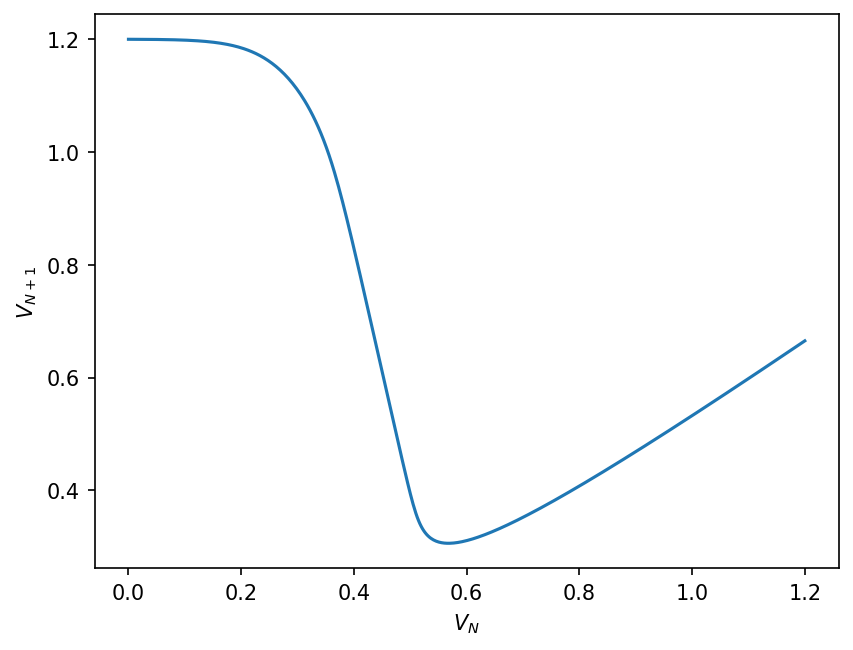

In [6]:
%%time

set_matplotlib_mode('inline', style=style)
Vin, Vout = simulate_ChaoGate_circuit(Vdd=1.2, Vbias=0.6, w1=w1, w2=w2, w3=w3, l1=l, l2=l, l3=l, steps=500, verbose=True)

plt.plot(Vin, Vout)
plt.xlabel('$V_N$')
_=plt.ylabel('$V_{N+1}$')


In [7]:
def generate_interpolated_transfer_func(*,
    Vdd:    float,
    Vbias:  float,
    w1:     float,
    w2:     float,
    w3:     float,
    l:      float=None,
    l1:     float=None,
    l2:     float=None,
    l3:     float=None,
    Vin:    float=None,
    Vss:    float=0,
    steps:  int=100,
    spice_library_path=path,
    verbose=False
):
    Vin, Vout = simulate_ChaoGate_circuit(Vdd=Vdd, 
        Vbias=Vbias, 
        w1=w1, 
        w2=w2, 
        w3=w3, 
        l=l,
        l1=l1, 
        l2=l2, 
        l3=l3, 
        Vin=Vin, 
        Vss=Vss, 
        spice_library_path=spice_library_path, 
        steps=steps, 
        verbose=verbose
    )
    interpolating_TF = interpolate.InterpolatedUnivariateSpline(Vin, Vout)
    return interpolating_TF
    
    

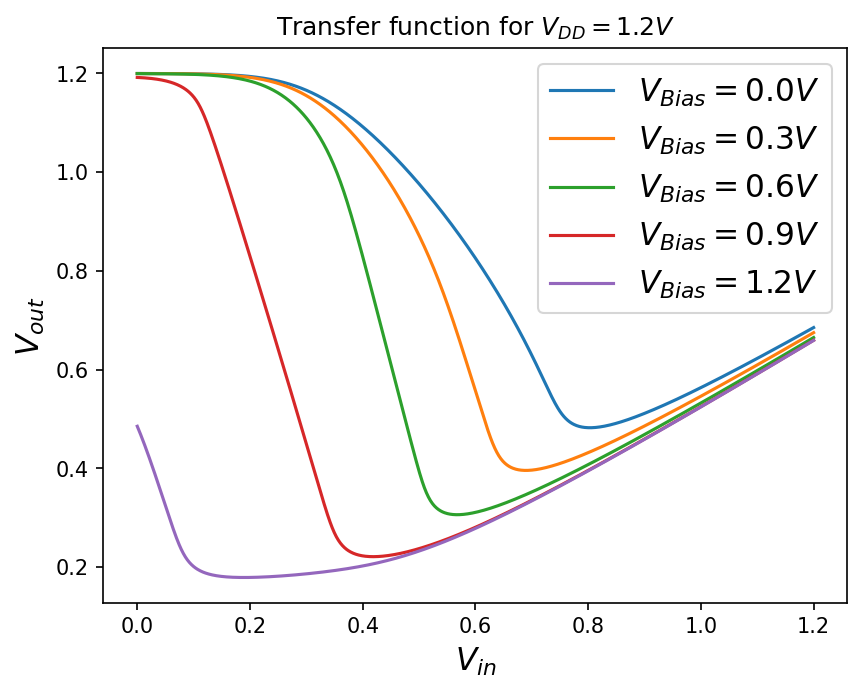

In [8]:
Vbias = [0., 0.3, 0.6, 0.9, 1.2]
vin = np.linspace(0, 1.2, 1000)

for vb in Vbias:
    tf = generate_interpolated_transfer_func(Vdd=1.2, Vbias=vb, w1=w1, w2=w2, w3=w3, l=l)
    plt.plot(vin, tf(vin), label=f'$V_{{Bias}} = {vb}V$')
plt.title('Transfer function for $V_{DD}=1.2V$')
plt.legend(fontsize=15)
plt.xlabel('$V_{in}$', fontsize=15)
plt.ylabel('$V_{out}$', fontsize=15)
plt.savefig('../../images/tf.png')

100 of 100 Operating Point evalutations done...
1000 of 1000 Operating Point evalutations done...
Root mean square error is:  5.40e-06V
Maximum error is:           6.70e-05V
CPU times: total: 10.3 s
Wall time: 3.02 s


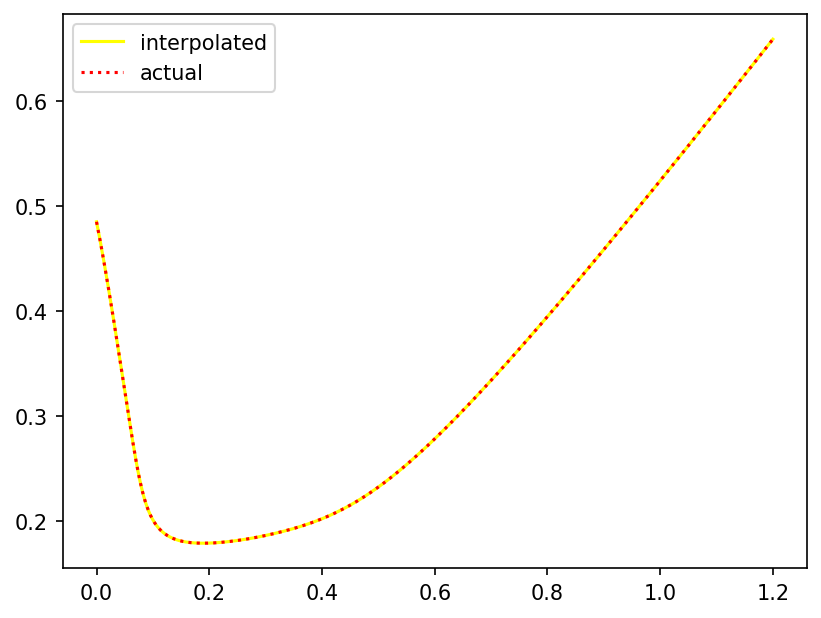

In [9]:
%%time
set_matplotlib_mode('inline', style)

vin = np.linspace(0, 1.2, 1000)

fn = generate_interpolated_transfer_func(Vdd=1.2, Vbias=1.2, w1=w1, w2=w2, w3=w3, l=l, verbose=True, steps=100)
vout_interpolated = fn(vin)

_,vout_actual = simulate_ChaoGate_circuit(Vin=vin, Vdd=1.2, Vbias=1.2, w1=w1, w2=w2, w3=w3, l=l, verbose=True, steps=1000)

diff = vout_interpolated - vout_actual
max_err = np.max(np.abs(diff))
rms_err = np.sqrt(np.mean(np.square(diff)))
print(f'Root mean square error is: {rms_err: .2e}V')
print(f'Maximum error is:          {max_err: .2e}V')

plt.plot(vin, vout_interpolated, label='interpolated', color='yellow')
plt.plot(vin, vout_actual, ':', label='actual', color='red')
_=plt.legend()

> ## Lyapunov Exponent
Let's now calculate the Lypapunov exponent ($\lambda$). For a chaotic map, one may expect $\lambda>0$. Consider two maps, one starting at $V_0$ and other at $V_0+dV$. Thus
$$\lambda(V_0)=\lim_{N \rightarrow \infty }\frac{1}{N} \ln\left|\frac{\delta(V_0, N)}{\delta(V_0, 0)}\right|$$
It turns out that the asymptotic lyapunov exponent is independent of the starting point $V_0$. Thus we may drop it from our notation.
> **Note**: Because of finite precision of computers and the divergence of $\ln(x)$ at $x=0$, we have to clip our results. As a result, for stable systems, the values may not converge to the same result.

> **Note**: In practive, it is observed that the running average lyapunov exponent converges very quickly. Thus we may use $N$ ~ $O(1000)$. In addition to that, we drop the first 100 values to avoid transient behaviour affecting our results

In [10]:
def calc_lyapunov_exponent_asymptotic(transfer_func, V0, *, N=1000, dv=1e-6):

    Vn, Vnd = np.zeros(N), np.zeros(N)
    vn, vnd = V0, V0+dv
    Vn[0], Vnd[0] = vn, vn+dv

    for i in range(1, N):
        vn = transfer_func(vn)
        vnd = transfer_func(vnd)
        Vnd[i], Vn[i] = vnd, vn
    
    M = 100 if N > 200 else N//2    
    Vn = Vn[M:]
    Vnd = Vnd[M:]
    delta_t = np.zeros(N-M)

    for i, (vn, vnd) in enumerate(zip(Vn, Vnd)):
        dV = (vnd - vn)/dv
        if dV == 0:
            dV = dv # log(0) is -inf, which is problematic. Hence clip results
        delta_t[i] = dV 

    abs_delta_t = np.abs(delta_t)
    ln_abs_delta_t = np.log(abs_delta_t)
    lya_exp = np.mean(ln_abs_delta_t)
    return lya_exp, Vn, Vnd
    xn = V0
    lya = 0
    fder = fn.derivative()
    for _ in range(300):
        xn = fn(xn)
    for _ in range(1000):
        xn = float(fn(xn))
        dx = fder(xn)
        lya += np.log(np.abs(dx))
    return lya/1000


     
fn = generate_interpolated_transfer_func(Vdd=1.2, Vbias=0.5, w1=w1, w2=w2, w3=w3, l=l)

V0_0, V0_1 = 0, 1

res0 = calc_lyapunov_exponent_asymptotic(fn, V0_0, N=2000)
res1 = calc_lyapunov_exponent_asymptotic(fn, V0_1, N=2000)

print(f'Lyapunov exponent when V0={V0_0}V is {res0:.3f}')
print(f'Lyapunov exponent when V0={V0_1}V is {res1:.3f}')


TypeError: unsupported format string passed to tuple.__format__

>## Choosing Bias Points:
Now, we plot $\lambda$, varying $V_{DD}$ from $0.6V$ to $1.3V$ and $V_{Bias}$ from $0V$ to $1.3V$ (Each having 100 steps).
> **Note**: Plotting the above graphs takes a lot of execution time (`~2Hrs` on this machine). In addition to that, there seems to be a memory leak in the PySPICE library. As a result, the peak memory required to perform the entire simulation would be `~114GB`. In the interest of time, we cache the results, and load them to generate the plots.

In [ ]:
def plot_lyapunov_exponent_grid(VBias, Vdd, *, verbose=False, cache_file=None, clip_negative=False, clip_positive=False):

    #set_matplotlib_mode('qt5')

    Vbias, VDD = np.linspace(*VBias), np.linspace(*Vdd)
    Vbias_, VDD_ = np.meshgrid(Vbias, VDD)
    Z = np.zeros(shape=Vbias_.shape)

    total_execs = len(Vbias) * len(VDD)

    if cache_file is not None:
        with open(cache_file, 'r') as f:
            lines = f.readlines()
        results = dict()
        for line in lines:
            vdd, vbias, lya_exp, W1, W2, W3, L = map(float, line.split())
            results[(vdd, vbias, W1, W2, W3, L)] = lya_exp
        file = open(cache_file, 'a')

    load, calculated, count = 0, 0, 0

    for i, vbias in enumerate(Vbias):
        for j, vdd in enumerate(VDD):
            if cache_file is not None and (vdd, vbias, w1, w2, w3, l) in results:
                res = results[(vdd, vbias, w1, w2, w3, l)]
                load += 1
            else:
                fn = generate_interpolated_transfer_func(Vdd=vdd, Vbias=vbias, w1=w1, w2=w2, w3=w3, l=65e-9)
                res = calc_lyapunov_exponent_asymptotic(fn, 0, N=100)
                if cache_file is not None:
                    f.write(f'{vdd} {vbias} {res} {w1} {w2} {w3} {l}\n')
                calculated += 1

            Z[j][i] = res
            if clip_positive:
                if Z[j][i] > 0:
                    Z[j][i] = 0

            if clip_negative:
                if Z[j][i] < 0:
                    Z[j][i] = 0
            
            count+=1

            if verbose:
                print(f'\r{count} of {total_execs} done...', end='')
    if verbose:
        print(f'\nloaded {load} results from cached file `{cache_file}`,'
              f'calculated {calculated} results, total {total_execs}')

    fig, ax = plt.subplots()
    cmap = cm.magma_r if clip_positive else cm.magma
    cs = ax.contourf(Vbias_, VDD_, Z, cmap=cmap)
    cbar = fig.colorbar(cs)
    ax.set_title('Lyapunov Exponent')
    ax.set_xlabel('$V_{Bias}$')
    ax.set_ylabel('$V_{DD}$')
    if cache_file is not None:
        f.close()
    mng = plt.get_current_fig_manager()
    mng.window.showMaximized()
    plt.savefig('../../images/lyapunov-vb-vdd.png', dpi=500)

In [ ]:
%%time

set_matplotlib_mode('qt5', style)

plot_lyapunov_exponent_grid(
    VBias=[0, 1.3, 100],
    Vdd=[0.6, 1.3, 100],
    cache_file='results.txt',
    clip_negative=False,
    verbose=False
)

CPU times: total: 547 ms
Wall time: 618 ms


Let us now plot the system, in the presence of noise. It is expected for systems with $\lambda>0$ to show divergence and those with $\lambda<0$ to converge. The magnitude of the noise will only affect the time required for convergance/divergance, but not whether its qualitative behaviour.
One may use the above $V_{Bias}$ vs $V_{DD}$ plot to choose the appropriate bias points.
> **Note**: In systems with $\lambda<0$, they may go out of phase

In [11]:
def calc_time_evolution(Vdd=1., Vbias=0.45, V0=None, dV=1e-3, N=1000, random_noise_amplitudes=None):
    random_noise_amplitudes = [] if random_noise_amplitudes is None else random_noise_amplitudes
    try:
        V0 = V0 if V0 is not None else float( v0_str:=input('Enter the value of Vo').rstrip('Vv') )
    except ValueError as e:
        print(f'Invalid value `{v0_str}` recieved for V0')
        raise e
    assert  -1.5 <= V0 <= 1.5, f'{V0=} is out of range [-1.5, 1.5]'

    fn = generate_interpolated_transfer_func(Vdd=Vdd, Vbias=Vbias, w1=w1, w2=w2, w3=w3, l=65e-9, steps=50)
    ly_exp = calc_lyapunov_exponent_asymptotic(fn, V0, N=N)
    print(f'Lyapunov Exponent = {ly_exp:.2f}')
    vn1, vn2 = V0, V0+dV
    Vn1 = [vn1]
    Vn2 = [vn2]
    Vnrnd = [[V0+dV+rna] for rna in random_noise_amplitudes]
    n = list(range(N))
    for _ in range(N-1):
        vn1 = fn(vn1)
        Vn1.append(vn1)
        vn2 = fn(vn2)
        Vn2.append(vn2)
        for Vrnd, amplitude in zip(Vnrnd, random_noise_amplitudes):
            vrnd = Vrnd[-1]
            vrnd = fn(vrnd) + 2 * amplitude * (np.random.random() - 0.5)
            Vrnd.append(vrnd)

    return Vn1, Vn2, Vnrnd, V0, ly_exp

In [12]:
def plot_time_evolution(
    Vdd=1., Vbias=0.45, V0=None, dV=0, 
    Nsim=1000,
    slider_init=1, slider_max=100, 
    random_noise_amplitudes=None,
    colours=['lime', 'blue', 'cyan', 'violet', 'orange']
):
    Vn1, Vn2, Vnrnd, V0, ly_exp = calc_time_evolution(Vdd=Vdd, Vbias=Vbias, V0=V0, dV=dV, N=Nsim, random_noise_amplitudes=random_noise_amplitudes)

    n = slider_init
    fig, ax = plt.subplots()
    line1, = ax.plot(list(range(n)), Vn1[:n], color='yellow', label=f'$V_0={V0}V$')
    if dV:
        line2, = ax.plot(list(range(n)), Vn2[:n], '--', color='red', label=f'$V_0={V0+dV}V$')
    line_rnd = [
        ax.plot(list(range(n)), Vrnd[:n], '--', color=colours[i], label=f'$V_0={V0+dV} +$ random noise')[0] if i < len(colours) else
        ax.plot(list(range(n)), Vrnd[:n], '--', label=f'$V_0={V0+dV} +$ noise = {Vrnd}')[0] for i, Vrnd in enumerate(Vnrnd)
        for i, Vrnd in enumerate(Vnrnd) 
    ]
    ax.set_xlim(0, slider_max)
    ax.set_ylim(0, 1.2)
    ax.set_title(f'Lyapunov Exponent $\lambda = ${ly_exp: .2f}, {dV = }V')
    fig.subplots_adjust(top=0.935, bottom=0.135, left=0.05, right=0.975)
    ax_N = fig.add_axes([0.2, 0.05, 0.65, 0.03])

    N_slider = Slider(
        ax=ax_N,
        label='time [N]',
        valmin=0,
        valmax=slider_max,
        valinit=slider_init,
        valstep=1
    )

    def update(val):
        n = N_slider.val
        line1.set_data(list(range(n)), Vn1[:n])
        if dV:
            line2.set_data(list(range(n)), Vn2[:n])
        for Vrnd, line in zip(Vnrnd, line_rnd):
            line.set_data(list(range(n)), Vrnd[:n])
            
        fig.canvas.draw_idle()

    N_slider.on_changed(update)
    ax.legend(loc='upper right')
    mng = plt.get_current_fig_manager()
    mng.window.showMaximized()
    return N_slider

In [13]:
# need keep a reference of slider, python garbage collector may clear it and plot will become unresponsive
_=plot_time_evolution(Vdd=1.1, Vbias=0.6, slider_init=30, slider_max=300, V0=0.1, random_noise_amplitudes=[], dV=0.0001)

# interesting behaviour is observed for Vdd=1V, Vbias=0.45V, V0=0.1V


TypeError: unsupported format string passed to tuple.__format__

>### Advantages and Disadvantages of the ChaoGate system:
From our above discussions, it is clear that the chaosgate described above is very sensitive to noise. In most realworld situations, the amount of noise observed is of the order of several millivolts. As a result we have to restrict the number of iterations accordingly. Moreover, the system is rather bulky, recall that we have not really dealt with how the iteration is performed. 

Despite the above, the proposed system also has several benefits:
1. It is more secure than the currently used `CMOS`-gate. It turns out that the current drawn, and thus the power consumed by different kinds of gates is different. As a result it is, in theory, possible to reverse engineer the implementation details.
2. While contemporay `FPGA`s and `CPLD`s exist, they have a huge overhead, but in terms of the number of gates and their powercomumption. Also not to mention the possibility of the aforementioned sidechannel attack.

In [11]:
fn = generate_interpolated_transfer_func(Vdd=1, Vbias=0.45, w1=w1, w2=w2, w3=w3, l=l)

In [21]:
set_matplotlib_mode('inline')

Vdd = np.linspace(0.6, 1.3, 500)
vbias = 0.45
Rp = []
Rn = []
for i, vdd in enumerate(Vdd):
    print(f'\r{i} of {len(Vdd)}', end='')
    fn = generate_interpolated_transfer_func(Vdd=vdd, Vbias=vbias, w1=w1, w2=w2, w3=w3, l=l, steps=100)
    xn = 0.5
    res = []
    lya, Vn, Vnd = calc_lyapunov_exponent_asymptotic(fn, 0, N=300)
    for j in range(0, len(Vn)):
        res.append(Vn[j])
        res.append(Vnd[j])
    if lya > 0:
        Rp.append((res, vdd))
        #plt.plot([vdd]*len(res), res, 'o', color='red', markersize=0.5)
    else:
        Rn.append((res, vdd))
        #plt.plot([vdd]*len(res), res, 'o', color='blue', markersize=0.5)


499 of 500

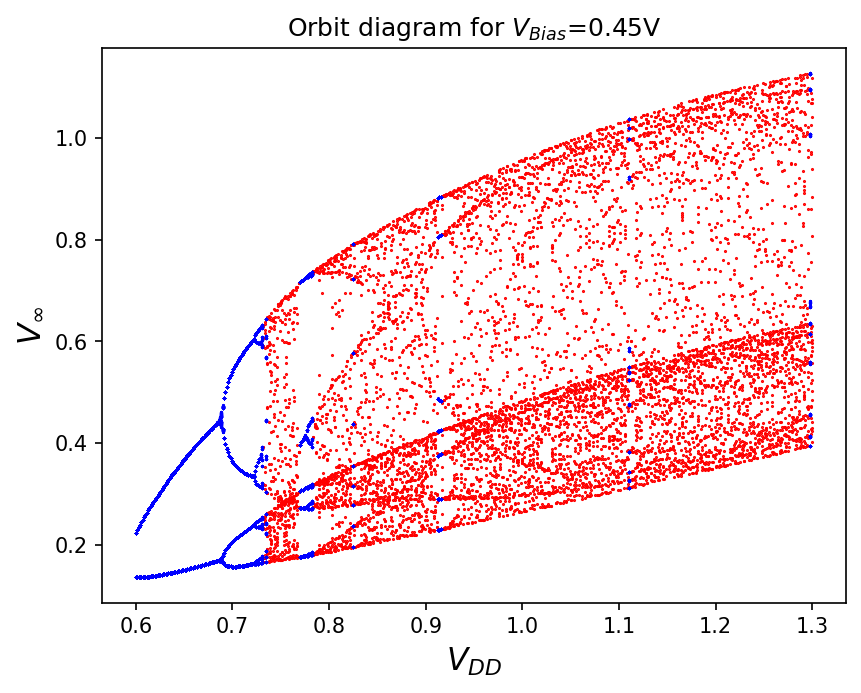

In [23]:
for r, vdd in Rp:
    r = r[:20]
    plt.plot([vdd]*len(r), r, 'o', color='red', markersize=0.5)
for r, vdd in Rn:
    plt.plot([vdd]*len(r), r, 'o', color='blue', markersize=0.5)
plt.xlabel('$V_{DD}$', fontsize=15)
plt.ylabel('$V_\infty$', fontsize=15)
plt.title(f'Orbit diagram for $V_{{Bias}}$=0.45V')
plt.savefig('../../images/orbit-diagram-Vdd')

In [16]:
set_matplotlib_mode('inline')

VBias=np.linspace(0, 1.3, 500)
vdd = 1.2
Rp = []
Rn = []
for i, vbias in enumerate(VBias):
    print(f'\r{i} of {len(VBias)}', end='')
    fn = generate_interpolated_transfer_func(Vdd=vdd, Vbias=vbias, w1=w1, w2=w2, w3=w3, l=l, steps=100)
    xn = 0.5
    res = []
    lya, Vn, Vnd = calc_lyapunov_exponent_asymptotic(fn, 0, N=300)
    for j in range(0, len(Vn)):
        res.append(Vn[j])
        res.append(Vnd[j])
    if lya > 0:
        Rp.append((res, vbias))
        #plt.plot([vdd]*len(res), res, 'o', color='red', markersize=0.5)
    else:
        Rn.append((res, vbias))
        #plt.plot([vdd]*len(res), res, 'o', color='blue', markersize=0.5)

239 of 500

In [ ]:
for r, vb in Rp:
    r = r[:20]
    plt.plot([vb]*len(r), r, 'o', color='red', markersize=0.5)
for r, vb in Rn:
    plt.plot([vb]*len(r), r, 'o', color='blue', markersize=0.5)
plt.xlabel('$V_{Bias}$', fontsize=15)
plt.ylabel('$V_\infty$', fontsize=15)
plt.title(f'Orbit diagram for $V_{{DD}}$=1.2V')
plt.savefig('../../images/orbit-diagram-Vdd')

C:\Users\Pari\AppData\Local\Temp\ipykernel_11908\2427870377.py:35: RuntimeWarning: divide by zero encountered in log
  lya += np.log(np.abs(dx))


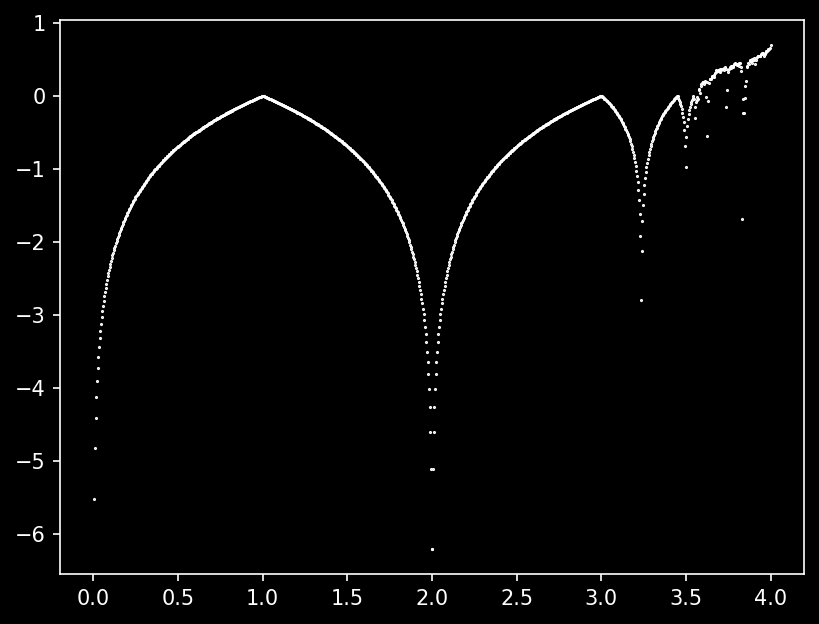

In [30]:
set_matplotlib_mode('inline')
A = np.linspace(0, 4, 1000)
for a in A:
    #fn = lambda x: a*x*(1-x)
    fn = interpolate.InterpolatedUnivariateSpline(A, a*A*(1-A))
    lya = calc_lyapunov_exponent_asymptotic(fn, 0.5)
    plt.plot([a], [lya], 'o', color='white', markersize=0.5)

99

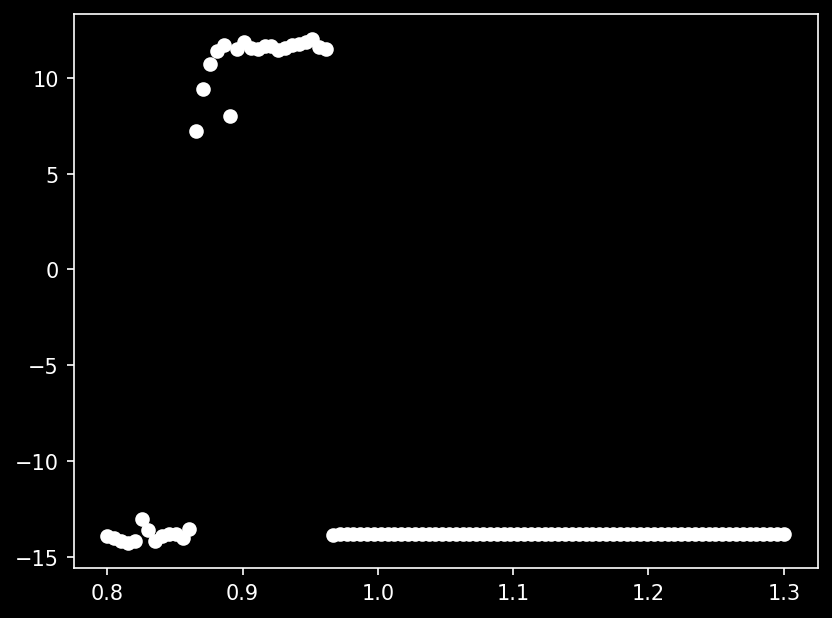

In [38]:
Vdd = np.linspace(0.8, 1.3, 100)
for i, vdd in enumerate(Vdd):
    print(f'\r{i}', end='')
    tf = generate_interpolated_transfer_func(Vdd=vdd, Vbias=0.6, w1=w1, w2=w2, w3=w3, l=l)
    lya = calc_lyapunov_exponent_asymptotic(tf, 0.5)
    l.append()

Lyapunov Exponent = 11.66


Lyapunov Exponent = 11.84


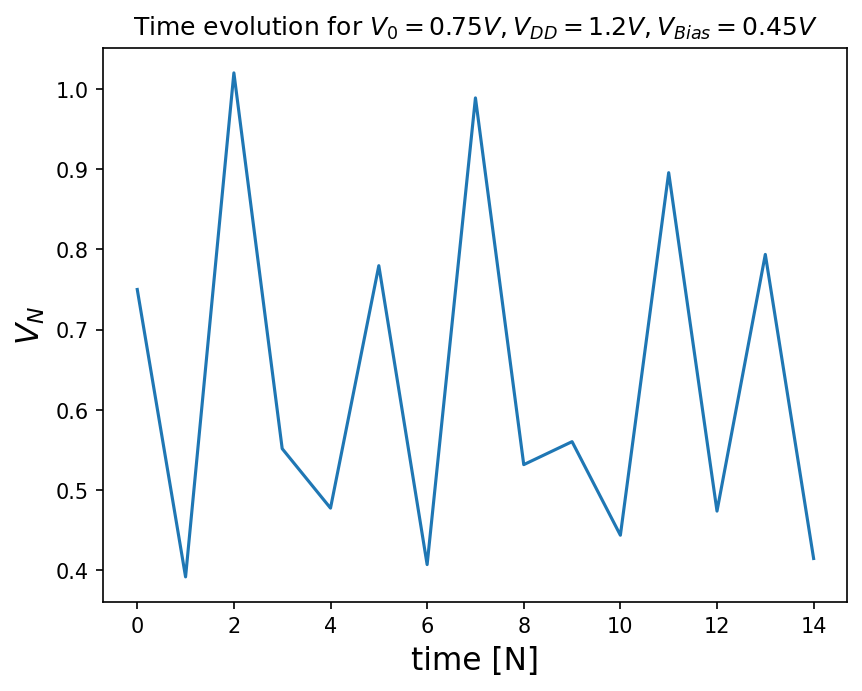

In [71]:
set_matplotlib_mode('inline')

Vn1, Vn2 = calc_time_evolution(V0=0.75, Vdd=1.2, Vbias=0.45)[0:2]
Vn1 = Vn1[:15]

plt.title('Time evolution for $V_0=0.75V, V_{DD}=1.2V, V_{Bias}=0.45V$')
plt.plot(list(range(len(Vn1))), Vn1)
plt.xlabel('time [N]', fontsize=15)
plt.ylabel('$V_N$', fontsize=15)
plt.savefig('../../images/time-evolution.png', dpi=1000)

1
